<a href="https://colab.research.google.com/github/djfLtC0dr/python-playground/blob/main/DASC522/djfDASC522hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem explanation:

We want to predict, without paying a premium subscription, the rate of perceived exertion or RPE one should apply based on as set of predictor variables. RPE is a continuous, numerical session-based variable that represent the level of effort exerted during a training session. The feature datasets are available via disparate data exports from two systems. FitBit tracks sleep data and SugarWOD tracks workout data. The intent is to combine the datasets and model via stepwise/P-Value, AIC-based, and RFE-based methods. It's a Supervised Regression task. 

Questions we may want to answer:

*   Is there a relationship between the predictors and RPE?
    * If so, how strong it this relationship?
*   Which predictors seem to have greatest impact?
*   Can we predict RPE with the predictors available?

Sqlite3 Database & Helper Classes

In [435]:
import sqlparse
from sqlparse.sql import IdentifierList, Identifier,  Function
from sqlparse.tokens import Keyword, DML
from collections import namedtuple
import itertools
import sqlite3
import os
import pandas as pd
from typing import List

class Reference(namedtuple('Reference', ['schema', 'name', 'alias', 'is_function'])):
    __slots__ = ()

    def has_alias(self):
        return self.alias is not None

    @property
    def is_query_alias(self):
        return self.name is None and self.alias is not None

    @property
    def is_table_alias(self):
        return self.name is not None and self.alias is not None and not self.is_function

    @property
    def full_name(self):
        if self.schema is None:
            return self.name
        else:
            return self.schema + '.' + self.name

def _is_subselect(parsed):
    if not parsed.is_group:
        return False
    for item in parsed.tokens:
        if item.ttype is DML and item.value.upper() in ('SELECT', 'INSERT',
                                                        'UPDATE', 'CREATE', 'DELETE'):
            return True
    return False


def _identifier_is_function(identifier):
    return any(isinstance(t, Function) for t in identifier.tokens)


def _extract_from_part(parsed):
    tbl_prefix_seen = False
    for item in parsed.tokens:
        if item.is_group:
            for x in _extract_from_part(item):
                yield x
        if tbl_prefix_seen:
            if _is_subselect(item):
                for x in _extract_from_part(item):
                    yield x
            # An incomplete nested select won't be recognized correctly as a
            # sub-select. eg: 'SELECT * FROM (SELECT id FROM user'. This causes
            # the second FROM to trigger this elif condition resulting in a
            # StopIteration. So we need to ignore the keyword if the keyword
            # FROM.
            # Also 'SELECT * FROM abc JOIN def' will trigger this elif
            # condition. So we need to ignore the keyword JOIN and its variants
            # INNER JOIN, FULL OUTER JOIN, etc.
            elif item.ttype is Keyword and (
                    not item.value.upper() == 'FROM') and (
                    not item.value.upper().endswith('JOIN')):
                tbl_prefix_seen = False
            else:
                yield item
        elif item.ttype is Keyword or item.ttype is Keyword.DML:
            item_val = item.value.upper()
            if (item_val in ('COPY', 'FROM', 'INTO', 'UPDATE', 'TABLE') or
                    item_val.endswith('JOIN')):
                tbl_prefix_seen = True
        # 'SELECT a, FROM abc' will detect FROM as part of the column list.
        # So this check here is necessary.
        elif isinstance(item, IdentifierList):
            for identifier in item.get_identifiers():
                if (identifier.ttype is Keyword and
                        identifier.value.upper() == 'FROM'):
                    tbl_prefix_seen = True
                    break

def _extract_table_identifiers(token_stream):
    for item in token_stream:
        if isinstance(item, IdentifierList):
            for ident in item.get_identifiers():
                try:
                    alias = ident.get_alias()
                    schema_name = ident.get_parent_name()
                    real_name = ident.get_real_name()
                except AttributeError:
                    continue
                if real_name:
                    yield Reference(schema_name, real_name,
                                    alias, _identifier_is_function(ident))
        elif isinstance(item, Identifier):
            yield Reference(item.get_parent_name(), item.get_real_name(),
                            item.get_alias(), _identifier_is_function(item))
        elif isinstance(item, Function):
            yield Reference(item.get_parent_name(), item.get_real_name(),
                            item.get_alias(), _identifier_is_function(item))

def extract_tables(sql):
    # let's handle multiple statements in one sql string
    extracted_tables = []
    statements = list(sqlparse.parse(sql))
    for statement in statements:
        stream = _extract_from_part(statement)
        extracted_tables.append([ref.name for ref in _extract_table_identifiers(stream)])
    return list(itertools.chain(*extracted_tables))

class CSVDriver:
    def __init__(self, table_dir_path: str):
        self.table_dir_path = table_dir_path  # where tables (ie. csv files) are located
        self._con = None

    @property
    def con(self) -> sqlite3.Connection:
        """Make a singleton connection to an in-memory SQLite database"""
        if not self._con:
            self._con = sqlite3.connect(":memory:")
        return self._con
    
    def _exists(self, table: str) -> bool:
        query = """
        SELECT name
        FROM sqlite_master 
        WHERE type ='table'
        AND name NOT LIKE 'sqlite_%';
        """
        tables = self.con.execute(query).fetchall()
        return table in tables

    def _load_table_to_mem(self, table: str, sep: str = None) -> None:
        """
        Load a CSV into an in-memory SQLite database
        sep is set to None in order to force pandas to auto-detect the delimiter
        """
        if self._exists(table):
            return
        file_name = table + ".csv"
        path = os.path.join(self.table_dir_path, file_name)
        if not os.path.exists(path):
            raise ValueError(f"CSV table {table} does not exist in {self.table_dir_path}")
        df = pd.read_csv(path, sep=sep, engine="python")  # set engine to python to skip pandas' warning
        df.to_sql(table, self.con, if_exists='replace', index=False, chunksize=10000)

    def query(self, query: str) -> List[tuple]:
        """
        Run an SQL query on CSV file(s). 
        Tables are loaded from table_dir_path
        """
        tables = extract_tables(query)
        for table in tables:
            self._load_table_to_mem(table)
        cursor = self.con.cursor()
        cursor.execute(query)  # 'execute' for 1 statement 'executescript' for many
        records = cursor.fetchall()
        return records

Data Prep => Need to get Dates & Timestamps in same format

In [436]:
import csv
from datetime import datetime

sleep = 'sleep'
ready = 'readiness'
workout = 'workout'
mdy_format = '%m/%d/%Y'
input_files = [sleep, ready, workout] 

def parse_date(input_file):
  """
  Output csv to formatted dates to 
  faciliate SQL Join
  """
  with open(f"/{input_file}.csv", 'r') as infile, open(f"/t_{input_file}.csv", 'w') as outfile:
    reader = csv.reader(infile)
    headers = next(reader, None)  # returns the headers or `None` if the input is empty
    writer = csv.writer(outfile)
    if headers:
      writer.writerow(headers) # write the header line
    if input_file == sleep:
      for row in reader:
        dt = datetime.fromisoformat(row[1].replace('Z', '+00:00')) #parse the datetime 
        row[1] = dt.strftime(mdy_format)           #assign the revised format
        writer.writerow(row)  
    elif input_file == ready:
      for row in reader:      
        dt = datetime.strptime(row[0], '%Y-%m-%d')    #parse the datetime
        row[0] = dt.strftime(mdy_format)     #assign the revised format
        writer.writerow(row) 
    else: # workout
      for row in reader:    
        writer.writerow(row) # workout date is in mdy_format
  return     

for input_file in input_files:
    parse_date(input_file)
 



Load tables from database into Pandas dataframe object

In [437]:
db_path = r"/"
driver = CSVDriver(db_path) 
# R.readiness_score_value, R.ff_normalized_score, R.hrv_normalized_score,
# LEFT JOIN t_readiness R
sel_query = """
SELECT S.overall_score, S.composition_score, S.revitalization_score, S.duration_score,
       S.deep_sleep_in_minutes, S.resting_heart_rate, S.restlessness,
       W.notes AS rpe
FROM t_sleep S
LEFT JOIN t_workout W
ON S.timestamp = W.date;
"""
# AND TRIM(W.pr) = 'PR';
data = pd.DataFrame.from_records(driver.query(sel_query))
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       615 non-null    int64  
 1   1       615 non-null    int64  
 2   2       615 non-null    int64  
 3   3       615 non-null    int64  
 4   4       615 non-null    int64  
 5   5       615 non-null    int64  
 6   6       615 non-null    float64
 7   7       523 non-null    object 
dtypes: float64(1), int64(6), object(1)
memory usage: 38.6+ KB
None


Data Prep => we need to subset data by mask where @RPE exists

In [438]:
mask = data[7].str.contains('@RPE', case=False, na=False)
data = data[mask]
# print(data.info())
# Extract all instances of RPE as int from notes = index 10
data[7] = data[7].str.extract(r'(@RPE+\d+)')
data[7] = data[7].str[4:].astype(float)
# 'readiness_score',
#     # 8: 'sleep_reservoir_lvl',
#     8: 'fitness_fatigue',
#     9: 'heart_rt_variability',

dict_col_names = {
    0: 'sleep_score',
    1: 'composite_score',
    2: 'revitalization_score',
    3: 'duration_score',
    4: 'deep_sleep_mins',
    5: 'resting_heart_rate',    
    6: 'restlessness',
    7: 'rpe'
}

data.rename(dict_col_names, axis=1, inplace=True)
print(data.info())
data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 0 to 614
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sleep_score           162 non-null    int64  
 1   composite_score       162 non-null    int64  
 2   revitalization_score  162 non-null    int64  
 3   duration_score        162 non-null    int64  
 4   deep_sleep_mins       162 non-null    int64  
 5   resting_heart_rate    162 non-null    int64  
 6   restlessness          162 non-null    float64
 7   rpe                   162 non-null    float64
dtypes: float64(2), int64(6)
memory usage: 11.4 KB
None


,sleep_score,composite_score,revitalization_score,duration_score,deep_sleep_mins,resting_heart_rate,restlessness,rpe
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,82.037037,20.203704,19.314815,42.518519,68.919753,52.777778,0.069186,5.734568
std,4.201285,1.536871,2.595917,2.359656,18.584365,1.762268,0.013829,4.271519
min,67.000000,15.000000,14.000000,35.000000,22.000000,48.000000,0.043157,1.000000
25%,79.000000,19.000000,17.000000,42.000000,56.000000,52.000000,0.059801,3.000000
50%,82.000000,21.000000,20.000000,43.000000,66.500000,53.000000,0.066818,5.000000
75%,85.000000,21.000000,21.000000,43.000000,82.000000,54.000000,0.075472,8.000000
max,90.000000,23.000000,24.000000,47.000000,121.000000,57.000000,0.116041,51.000000


Data clean-up => fix outlier(s), DU

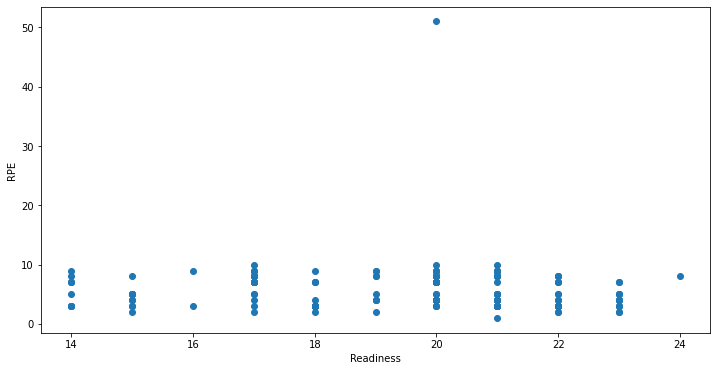

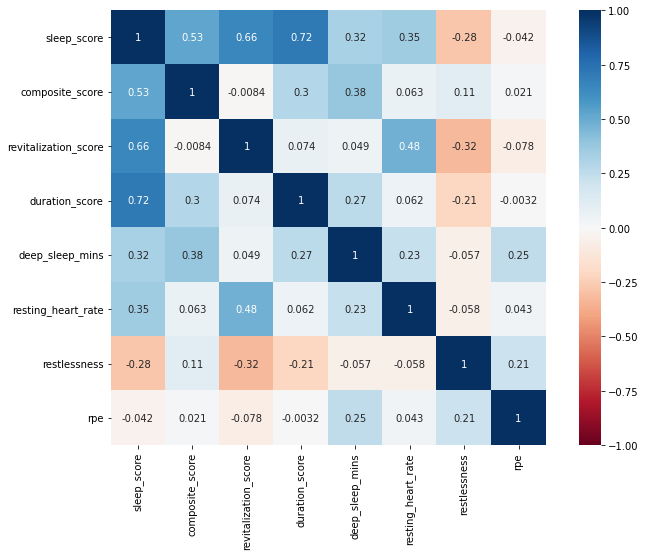

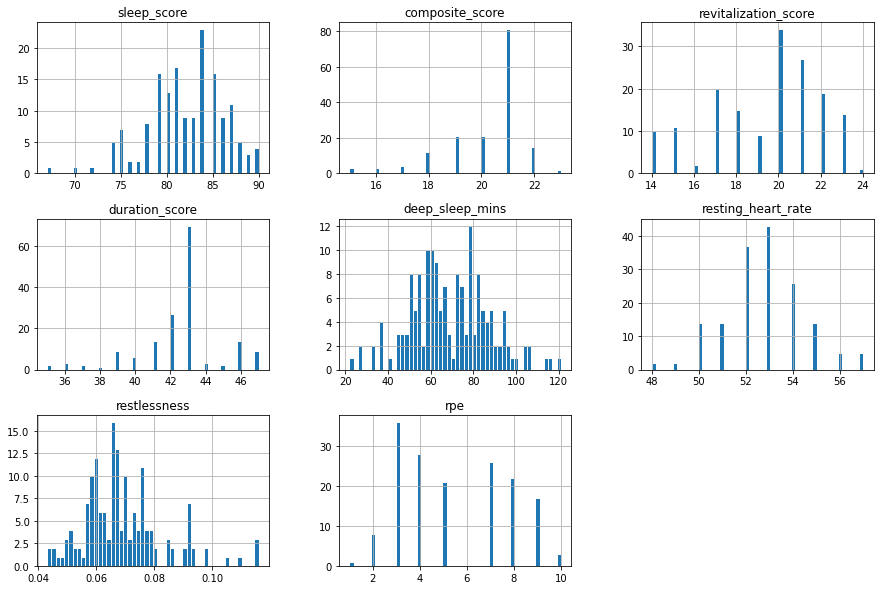

       sleep_score  composite_score  revitalization_score  duration_score  \
count   162.000000       162.000000            162.000000      162.000000   
mean     82.037037        20.203704             19.314815       42.518519   
std       4.201285         1.536871              2.595917        2.359656   
min      67.000000        15.000000             14.000000       35.000000   
25%      79.000000        19.000000             17.000000       42.000000   
50%      82.000000        21.000000             20.000000       43.000000   
75%      85.000000        21.000000             21.000000       43.000000   
max      90.000000        23.000000             24.000000       47.000000   

       deep_sleep_mins  resting_heart_rate  restlessness         rpe  
count       162.000000          162.000000    162.000000  162.000000  
mean         68.919753           52.777778      0.069186    5.450617  
std          18.584365            1.762268      0.013829    2.332733  
min          22.000000

In [439]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(data['revitalization_score'], data['rpe'])
ax.set_xlabel('Readiness')
ax.set_ylabel('RPE')
plt.show()

# Z score
z = np.abs(stats.zscore(data['rpe']))
threshold = 3

# Position of the outlier
idx_outlier = np.where(z > threshold)
# print(data.iloc[idx_outlier])

median_rpe = data['rpe'].quantile(0.50)
outlier_rpe = data['rpe'].quantile(0.9915)
# print(outlier_rpe)
# Any thing over 10 needs to be replaced with the median rpe
data['rpe'] = np.where(data['rpe'] > outlier_rpe, int(median_rpe), data['rpe'])

# correlation matrix
fig, ax = plt.subplots(figsize=(12,8)) 
sns.heatmap(data.corr(), cmap='RdBu', vmin=-1, vmax=1, annot=True, square=True, ax=ax)

#visualizing distributions 
data.hist(bins=50, figsize=(15,10), ec='w')
plt.show()
#not all data is normal, we have some skewdness => will need to transform

print(data.describe())

Feature Names helper classes

In [440]:
!pip install skimpy
from skimpy import clean_columns
from sklearn.utils.validation import check_is_fitted

def get_column_names_from_ColumnTransformer(column_transformer, clean_column_names=True, verbose=True):  

    """
    Reference: Kyle Gilde: https://github.com/kylegilde/Kaggle-Notebooks/blob/master/Extracting-and-Plotting-Scikit-Feature-Names-and-Importances/feature_importance.py
    Description: Get the column names from the a ColumnTransformer containing transformers & pipelines
    Parameters
    ----------
    verbose: Bool indicating whether to print summaries. Default set to True.
    Returns
    -------
    a list of the correct feature names
    Note:
    If the ColumnTransformer contains Pipelines and if one of the transformers in the Pipeline is adding completely new columns,
    it must come last in the pipeline. For example, OneHotEncoder, MissingIndicator & SimpleImputer(add_indicator=True) add columns
    to the dataset that didn't exist before, so there should come last in the Pipeline.
    Inspiration: https://github.com/scikit-learn/scikit-learn/issues/12525
    """

    assert isinstance(column_transformer, ColumnTransformer), "Input isn't a ColumnTransformer"
    
    check_is_fitted(column_transformer)

    new_feature_names, transformer_list = [], []

    for i, transformer_item in enumerate(column_transformer.transformers_): 
        transformer_name, transformer, orig_feature_names = transformer_item
        orig_feature_names = list(orig_feature_names)

        if len(orig_feature_names) == 0:
            continue

        if verbose: 
            print(f"\n\n{i}.Transformer/Pipeline: {transformer_name} {transformer.__class__.__name__}\n")
            print(f"\tn_orig_feature_names:{len(orig_feature_names)}")

        if transformer == 'drop':
            continue

        if isinstance(transformer, Pipeline):
            # if pipeline, get the last transformer in the Pipeline
            transformer = transformer.steps[-1][1]

        if hasattr(transformer, 'get_feature_names_out'):
            if 'input_features' in transformer.get_feature_names_out.__code__.co_varnames:
                names = list(transformer.get_feature_names_out(orig_feature_names))
            else:
                names = list(transformer.get_feature_names_out())
        elif hasattr(transformer, 'get_feature_names'):
            if 'input_features' in transformer.get_feature_names.__code__.co_varnames:
                names = list(transformer.get_feature_names(orig_feature_names))
            else:
                names = list(transformer.get_feature_names())

        elif hasattr(transformer,'indicator_') and transformer.add_indicator:
            # is this transformer one of the imputers & did it call the MissingIndicator?

            missing_indicator_indices = transformer.indicator_.features_
            missing_indicators = [orig_feature_names[idx] + '_missing_flag'\
                                  for idx in missing_indicator_indices]
            names = orig_feature_names + missing_indicators

        elif hasattr(transformer,'features_'):
            # is this a MissingIndicator class? 
            missing_indicator_indices = transformer.features_
            missing_indicators = [orig_feature_names[idx] + '_missing_flag'\
                                  for idx in missing_indicator_indices]

        else:

            names = orig_feature_names

        if verbose: 
            print(f"\tn_new_features:{len(names)}")
            print(f"\tnew_features: {names}\n")

        new_feature_names.extend(names)
        transformer_list.extend([transformer_name] * len(names))

    transformer_list, column_transformer_features = transformer_list, new_feature_names

    if clean_column_names:
        new_feature_names = list(clean_columns(pd.DataFrame(columns=new_feature_names)).columns)
    
    return new_feature_names

def extract_feature_names(model, name) -> List[str]:
  """Extracts the feature names from arbitrary sklearn models
  Args:
    model: The Sklearn model, transformer, clustering algorithm, etc. which we want to get named features for.
    name: The name of the current step in the pipeline we are at.
    
  Returns:
    The list of feature names.  If the model does not have named features it constructs feature names
    by appending an index to the provided name.
  """
  if hasattr(model, "get_feature_names"):
      return model.get_feature_names()
  elif hasattr(model, "n_clusters"):
      return [f"{name}_{x}" for x in range(model.n_clusters)]
  elif hasattr(model, "n_components"):
      return [f"{name}_{x}" for x in range(model.n_components)]
  elif hasattr(model, "components_"):
      n_components = model.components_.shape[0]
      return [f"{name}_{x}" for x in range(n_components)]
  elif hasattr(model, "classes_"):
      return model.classes_
  else:
      return [name]

from sklearn.pipeline import FeatureUnion, Pipeline
def get_feature_names(model, names: List[str], name: str) -> List[str]:
    """Thie method extracts the feature names in order from a Sklearn Pipeline
    
    This method only works with composed Pipelines and FeatureUnions.  It will
    pull out all names using DFS from a model.
    
    Args:
        model: The model we are interested in
        names: The list of names of final featurizaiton steps
        name: The current name of the step we want to evaluate.
    
    Returns:
        feature_names: The list of feature names extracted from the pipeline.
    """
    
    # Check if the name is one of our feature steps.  This is the base case.
    if name in names:
        # If it has the named_steps atribute it's a pipeline and we need to access the features
        if hasattr(model, "named_steps"):
            return extract_feature_names(model.named_steps[name], name)
        # Otherwise get the feature directly
        else:
            return extract_feature_names(model, name)
    elif type(model) is Pipeline:
        feature_names = []
        for name in model.named_steps.keys():
            feature_names += get_feature_names(model.named_steps[name], names, name)
        return feature_names
    elif type(model) is FeatureUnion:
        feature_names= []
        for name, new_model in model.transformer_list:
            feature_names += get_feature_names(new_model, names, name)
        return feature_names
    # If it is none of the above do not add it.
    else:
        return []

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Data Prep => Multicollinearity

In [441]:
#Applying multicollinearity to remove columns which are dependent on each other
# From looking at documentation, values between 5 and 10 are "okay".
# Above 10 is too high and so should be removed.
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=25, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        # I'm going to set it to 25 and see what happens
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = SimpleImputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            try:
                vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
                max_vif = max(vif)
                if max_vif > thresh:
                    maxloc = vif.index(max_vif)
                    print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                    X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                    dropped=True
            except ValueError:  #raised if `vif` is empty.
                pass
        return X

# Remove columns having higher VIF factor that have high multicollinearity
multicollinearity = ReduceVIF()
data = multicollinearity.fit_transform(data)

ReduceVIF fit
ReduceVIF transform
Dropping sleep_score with vif=inf
Dropping resting_heart_rate with vif=487.7102066907202
Dropping composite_score with vif=204.691463138557
Dropping duration_score with vif=96.94690133267203


Feature Engineering => Split, Best Features via PCA/R

In [442]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from typing import List
import warnings
warnings.filterwarnings('ignore')

def get_impt_features(pipe) -> List[str]:
  selector = pipe.named_steps['selector']
  all_features = [*numeric_features]  # categorical_features,unpack both iterables in a list literal
  mask = selector.get_support()
  df_features = pd.DataFrame()
  df_features['pval'] = selector.pvalues_
  df_features['fscore'] = selector.scores_
  df_features['impt'] = mask
  df_features['feat_name'] = get_column_names_from_ColumnTransformer(preprocessor, verbose=False) #pd.Series(get_feature_names(mask, all_features))
  df_features.sort_values(by=['pval'], inplace=True)
  return df_features

# Split the data X, y
# separate the independent and dependent variables
X = data.loc[:, data.columns != 'rpe']
y = data.loc[:, data.columns == 'rpe']
X = sm.add_constant(X)

# for future piping
numeric_features = list(X.select_dtypes(include=['float64', 'int64']).columns)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# feature pipelines
pipe=Pipeline(steps=[('preprocessor', preprocessor),
                     ('pca', PCA()),
                     ('selector', SelectKBest(score_func=f_regression, k=3))]) # features selected

# split normd data into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

# Define the parameter to vary. Here's the number of PC
pcr_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA() ), ('linear_regression', LinearRegression())])
parameters = {'pca__n_components':np.arange(1,7,1)}
 
# Use GridSearchCV to find the optimal parameter(s) in cross-validation
pcr = GridSearchCV(pcr_pipe, parameters, scoring = 'neg_mean_squared_error')
# Fit the instance
pcr.fit(X_train, y_train)
# Print the result
print(pcr.best_estimator_) # => n_components=3

pipe.fit(X_train, y_train)
features = get_impt_features(pipe)
 
print("Selected best:")
print(features.loc[features['impt'] == True])



Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=3)),
                ('linear_regression', LinearRegression())])
Selected best:
       pval    fscore  impt             feat_name
0  0.002845  9.314313  True                 const
1  0.007888  7.321694  True  revitalization_score
2  0.106281  2.651597  True       deep_sleep_mins


Modeling => P-vals

In [443]:
import statsmodels.formula.api as smf
#Fitting multiple Linear Regression to Training set
regressor = LinearRegression()
regressor.fit(X, y)

full_regressor_OLS = sm.OLS(endog = y, exog = X).fit()
print(full_regressor_OLS.summary())

# drop all pvals > 0.05
pvals = X.drop(['revitalization_score'], axis=1)
pvals_regressor_OLS = sm.OLS(endog = y, exog = pvals).fit()
print(pvals_regressor_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                    rpe   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     6.917
Date:                Tue, 01 Nov 2022   Prob (F-statistic):           0.000210
Time:                        21:03:33   Log-Likelihood:                -356.59
No. Observations:                 162   AIC:                             721.2
Df Residuals:                     158   BIC:                             733.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.8982 

Modeling => AIC

In [446]:
###  Build Every Possible Model
from itertools import chain, combinations

def powerset(iterable):
    s=list(iterable)
    return chain.from_iterable(combinations(s,r) for r in range(1, len(s)+1))
    
mylist=list(powerset(list(X.columns)))
mylist=[list(row) for row in mylist]

##Target is AIC
AIC_scores=pd.DataFrame(columns=["AIC"])
for i in range(len(mylist)):
    AIC_scores.loc[i,'AIC']=sm.OLS(y,X[mylist[i]]).fit().aic
    
print(AIC_scores.sort_values(by='AIC').head(10))
print(mylist[9])

aic_model = smf.ols('rpe ~ deep_sleep_mins + restlessness', data=data).fit() 
predictions = aic_model.predict(X) 
print_model = aic_model.summary()
print(print_model)

           AIC
9   717.439671
12  719.247112
13  719.391396
14  721.184217
5   726.470705
10  727.048636
6   729.662191
11  731.645614
8   732.319912
0    735.17419
['deep_sleep_mins', 'restlessness']
                            OLS Regression Results                            
Dep. Variable:                    rpe   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     10.41
Date:                Tue, 01 Nov 2022   Prob (F-statistic):           5.66e-05
Time:                        21:10:07   Log-Likelihood:                -356.62
No. Observations:                 162   AIC:                             719.2
Df Residuals:                     159   BIC:                             728.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
         

Modeling => RFE

In [445]:
regressor = LinearRegression()
print("\nSearch the best k features for k = 1 to 7\n")

for k in range(1, 7):
  selector = RFE(estimator=regressor, n_features_to_select=k)
  
  # feature pipelines
  pipe=Pipeline(steps=[('preprocessor', preprocessor),
                      ('pca', PCA()),
                      #('estimator', estimator),
                      ('selector', selector)]) # features selected

  # filter = selector.support_
  # ranking = selector.ranking_

  # print("Mask data: ", filter)
  # print("Ranking: ", ranking)

  fit = pipe.fit(X, y)
  selector = pipe.named_steps['selector']
  f = selector.get_support(1) #the most important features

  # final_features = data[data.columns[f]] # final features: this gives wrong results
  final_features = X[X.columns[f]] # final features

  print("Num Features: %d" % selector.n_features_)
  print("Selected Features: %s" % final_features.columns)
  print("Score: %2.2f" % fit.score(X,y))
  print("----------")

rfe_model = smf.ols('rpe ~ revitalization_score + deep_sleep_mins + restlessness', data=data).fit() 
predictions = rfe_model.predict(X) 
print_model = rfe_model.summary()
print(print_model)


Search the best k features for k = 1 to 7

Num Features: 1
Selected Features: Index(['revitalization_score'], dtype='object')
Score: 0.09
----------
Num Features: 2
Selected Features: Index(['revitalization_score', 'deep_sleep_mins'], dtype='object')
Score: 0.10
----------
Num Features: 3
Selected Features: Index(['const', 'revitalization_score', 'deep_sleep_mins'], dtype='object')
Score: 0.12
----------
Num Features: 4
Selected Features: Index(['const', 'revitalization_score', 'deep_sleep_mins', 'restlessness'], dtype='object')
Score: 0.12
----------
Num Features: 4
Selected Features: Index(['const', 'revitalization_score', 'deep_sleep_mins', 'restlessness'], dtype='object')
Score: 0.12
----------
Num Features: 4
Selected Features: Index(['const', 'revitalization_score', 'deep_sleep_mins', 'restlessness'], dtype='object')
Score: 0.12
----------
                            OLS Regression Results                            
Dep. Variable:                    rpe   R-squared:            

Model Evaluation:

The data analysis began by exporting the data in CSV format then preparing the data by joining the files by date. The data cleaning steps included fixing outliers and extracting RPE from session notes and formatting it as float.

After the data understanding, it was clear we had some multicollinearity issues to fix. After running the VIF function we were down to three significant features. I validated this with RPA/C dimension reduction pipelines.

For best P-value modeling StatsModels.OLS regression was used to summaraize the model. revitalization_score, with a P-value of  0.780 was dropped, slightly improving  Adj. R-squared and left two significant features, shown here with their respective P-value: 


1.   deep_sleep_mins          0.001       
2.   restlessness             0.003

R-squared: 0.116

The AIC modeling leveraged the itertools library to perform an "Every model possible" build. This analysis returned the same significant variables as the P-value modeling; albeit with slightly more deep_sleep_mins significance:

1.   deep_sleep_mins          0.0001       
2.   restlessness             0.003

R-squared: 0.116 

Lastly, RFE modeling iterated over the seven available features and determined the three best scoring features were:

1.   deep_sleep_mins          0.001 
2.   restlessness             0.006
3.   revitalization_score     0.805

R-squared: 0.116